# Data loading 
Next cells are used to load the data we need.

In [1]:
import pandas as pd
import numpy as np 
import scipy.sparse as sps
import os
import sys
import matplotlib.pyplot as plt
sys.path.append('..')


In [2]:
#data which contains users (row), items(col) and implicit interaction (data)
#dataset = pd.read_csv('data_train.csv')
dataset = pd.read_csv('data_train.csv', names=["user", "item", "interaction"], header=0)
dataset

,user,item,interaction
0,0,10080,1.0
1,0,19467,1.0
2,1,2665,1.0
3,1,7494,1.0
4,1,17068,1.0
...,...,...,...
113263,7945,2476,1.0
113264,7945,12319,1.0
113265,7945,21384,1.0
113266,7946,8699,1.0


# Data pre-processing
Pre-processing of data to check for missing users, items ecc...

In [3]:
def list_ID_stats(ID_list, label):
    
    min_val = min(ID_list)
    max_val = max(ID_list)
    unique_val = len(set(ID_list))
    missing_val = 1 - unique_val/(max_val - min_val)

    print("{} data, ID: min {}, max {}, unique {}, missig {:.2f} %".format(label, min_val, max_val, unique_val, missing_val*100))

list_ID_stats(dataset.user, "User")
list_ID_stats(dataset.item, "Item")

User data, ID: min 0, max 7946, unique 7947, missig -0.01 %
Item data, ID: min 0, max 25974, unique 24896, missig 4.15 %


If the difference between the unique elements and the max/min ones is really big, it's better to remap users and items in a new dataframe. In this case, it seems I can leave it as it is

In [4]:
users = dataset.user
items = dataset.item
interaction = dataset.interaction
URM_all = sps.coo_matrix((interaction, (users, items)))
URM_all = URM_all.tocsr() #fast row access -> fast access to users 
URM_all.shape

(7947, 25975)

In [5]:
from Base.Evaluation.Evaluator import EvaluatorHoldout
from Data_manager.split_functions.split_train_validation_random_holdout import split_train_in_two_percentage_global_sample

#splitting data into train and test. In teoria non serve, da vedere
#URM_train, URM_test = split_train_in_two_percentage_global_sample(URM_all, train_percentage = 0.85)

#splitting data into train and validation (from the previous training data)
URM_train, URM_validation = split_train_in_two_percentage_global_sample(URM_all, train_percentage = 0.85)



In [6]:
#evaluator for validation (used for hyperparameter tuning)
evaluator_validation = EvaluatorHoldout(URM_validation, cutoff_list=[10])

#evaluator for testing (the final one)
#evaluator_test = EvaluatorHoldout(URM_test, cutoff_list=[10])

In [8]:
from GraphBased.P3alphaRecommender_user import P3alphaRecommender_user

recommender_alpha_user = P3alphaRecommender_user(URM_train.T)
recommender_alpha_user.fit(topK=100, alpha = 0.5, implicit = True)
recommender_alpha_user.URM_train = URM_train
evaluator_validation.evaluateRecommender(recommender_alpha_user)

P3alphaRecommender_user: URM Detected 2018 (7.77 %) cold users.
P3alphaRecommender_user: URM Detected 53 (0.67 %) cold items.
EvaluatorHoldout: Processed 4940 ( 100.00% ) in 5.67 sec. Users per second: 871


({10: {'ROC_AUC': 0.1491691809652338,
   'PRECISION': 0.02888663967611288,
   'PRECISION_RECALL_MIN_DEN': 0.11500650665124358,
   'RECALL': 0.11280831667638343,
   'MAP': 0.05426930762370921,
   'MRR': 0.10910280508964706,
   'NDCG': 0.08066559341294985,
   'F1': 0.045995330817463,
   'HIT_RATE': 0.2888663967611336,
   'ARHR': 0.12152344001028215,
   'NOVELTY': 0.004815973277580495,
   'AVERAGE_POPULARITY': 0.10869116140676029,
   'DIVERSITY_MEAN_INTER_LIST': 0.9862314569734567,
   'DIVERSITY_HERFINDAHL': 0.9986031814978118,
   'COVERAGE_ITEM': 0.3693936477382098,
   'COVERAGE_ITEM_CORRECT': 0.03303176130895091,
   'COVERAGE_USER': 0.6216182207122184,
   'COVERAGE_USER_CORRECT': 0.14194035485088713,
   'DIVERSITY_GINI': 0.11641077438033738,
   'SHANNON_ENTROPY': 11.403282263039443}},
 'CUTOFF: 10 - ROC_AUC: 0.1491692, PRECISION: 0.0288866, PRECISION_RECALL_MIN_DEN: 0.1150065, RECALL: 0.1128083, MAP: 0.0542693, MRR: 0.1091028, NDCG: 0.0806656, F1: 0.0459953, HIT_RATE: 0.2888664, ARHR: 0

In [9]:
recommender_alpha_user.W_sparse.shape

(7947, 7947)

In [10]:
x_tick = []
collaborative_MAP = []
maxMAP = 0
maxXTick = ""

for topK in [50,100,150,200,250,300,350,400]:
    for alpha in [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]:
        
        x_tick.append("topk {}, alpha {}".format(topK, alpha))

        
        recommender = P3alphaRecommender_user(URM_train.T)
        recommender.fit(topK=topK, alpha = alpha, implicit = True)
        recommender.URM_train = URM_train
    
        result_dict, _ = evaluator_validation.evaluateRecommender(recommender)

        collaborative_MAP.append(result_dict[10]["MAP"])

P3alphaRecommender_user: URM Detected 2018 (7.77 %) cold users.
P3alphaRecommender_user: URM Detected 53 (0.67 %) cold items.
EvaluatorHoldout: Processed 4940 ( 100.00% ) in 4.46 sec. Users per second: 1108
P3alphaRecommender_user: URM Detected 2018 (7.77 %) cold users.
P3alphaRecommender_user: URM Detected 53 (0.67 %) cold items.
EvaluatorHoldout: Processed 4940 ( 100.00% ) in 4.32 sec. Users per second: 1143
P3alphaRecommender_user: URM Detected 2018 (7.77 %) cold users.
P3alphaRecommender_user: URM Detected 53 (0.67 %) cold items.
EvaluatorHoldout: Processed 4940 ( 100.00% ) in 4.01 sec. Users per second: 1233
P3alphaRecommender_user: URM Detected 2018 (7.77 %) cold users.
P3alphaRecommender_user: URM Detected 53 (0.67 %) cold items.
EvaluatorHoldout: Processed 4940 ( 100.00% ) in 4.18 sec. Users per second: 1181
P3alphaRecommender_user: URM Detected 2018 (7.77 %) cold users.
P3alphaRecommender_user: URM Detected 53 (0.67 %) cold items.
EvaluatorHoldout: Processed 4940 ( 100.00% ) i

In [11]:
import operator
index, value = max(enumerate(collaborative_MAP), key=operator.itemgetter(1))
print(index, value)
parameters = x_tick[index]
print(parameters)

19 0.05556677079476257
topk 150, alpha 0.2


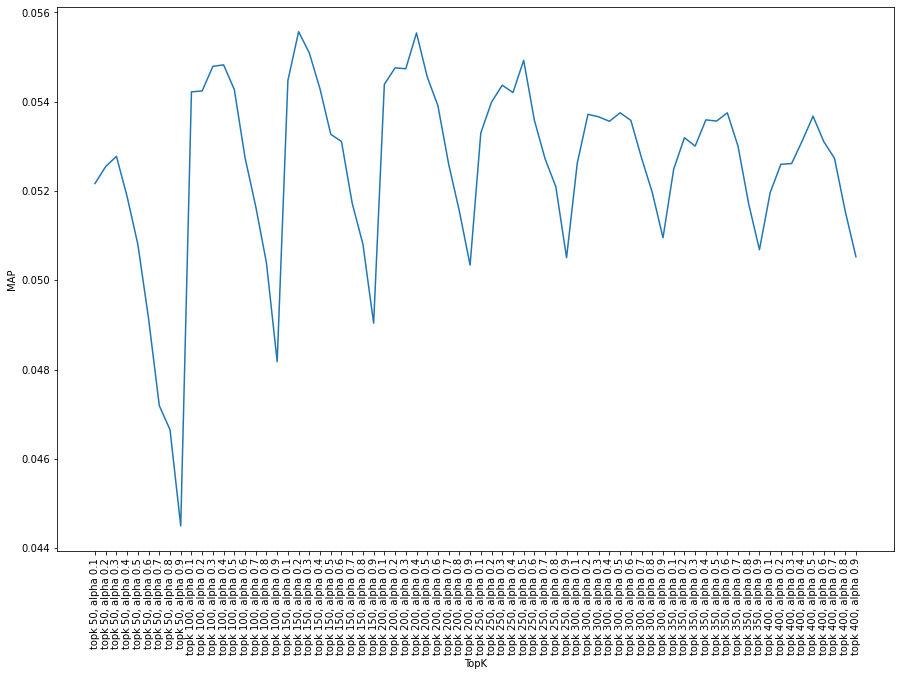

In [13]:
# 0.059361413681482254
#topk 450, shrink 750 similarity = cosine Best model here, the previous ones are tests. 

plt.figure(figsize=(15,10))
plt.plot(x_tick, collaborative_MAP, label="Collaborative", )
plt.ylabel('MAP')
plt.xlabel('TopK')
plt.xticks(rotation='vertical')
plt.show()

In [ ]:
test_users = pd.read_csv('data_target_users_test.csv')
test_users

In [ ]:
recommender = ItemKNNCFRecommender(URM_all)
recommender.fit(shrink=600, topK=550, feature_weighting = "TF-IDF")

user_id = test_users['user_id']
recommendations = recommender.recommend(user_id, cutoff = 10)


In [ ]:
for index in range(len(recommendations)):
    #print(element)
    recommendations[index]=np.array(recommendations[index])
    #print(type(element))
print(len(recommendations))

In [ ]:
test_users['item_list']= recommendations
#test_users['item_list'] =  test_users['item_list'].apply(lambda x: x.replace('[','').replace(']','')) 
test_users['item_list'] = pd.DataFrame([str(line).strip('[').strip(']').replace("'","") for line in test_users['item_list']])

#convert the string columns to int
#test_users['item_list'] = test_users['item_list'].astype(int)
test_users
test_users.to_csv('submission.csv', index=False)
